In [ ]:
! which python3
! python3 -V

Legend: 
0: cyfronet, 1: uci,  2: ftj,  3: b1,  4: b6,  5: ms


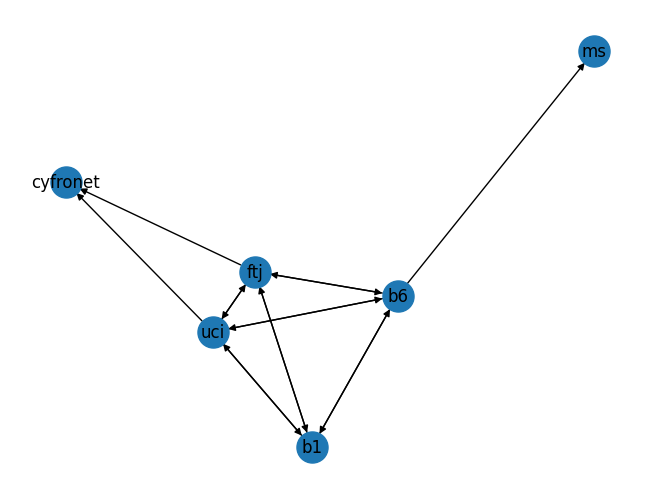

In [3]:
# implementation of 
# https://re.public.polimi.it/retrieve/handle/11311/1079801/349976/PID5815733-pdfexpress.pdf

import jraph
import jax.numpy as jnp
import networkx as nx
from metadata import *
import utils


###  TODO:
# TODO: create a file with utils for drawing and so on
# TODO: maybe do mapping in nx int -> string

_senders = []
_receivers = []

for x, row in enumerate(ADJACENCY_MATRIX):
    for y, _ in enumerate(row):
        if ADJACENCY_MATRIX[x][y]:
            _senders.append(x)
            _receivers.append(y)

senders = jnp.array(_senders)
receivers = jnp.array(_receivers)
nodes = jnp.array([1] * NUM_NODES)
edges = jnp.array([1] * NUM_EDGES)

p = """Legend: 
0: cyfronet, 1: uci,  2: ftj,  3: b1,  4: b6,  5: ms"""
print(p)
# print(senders)
# print(receivers)

graph_features = jnp.array([[1]])
graph = jraph.GraphsTuple(
    nodes=None,
    edges=None,
    senders=senders,
    receivers=receivers,
    n_node=jnp.asarray([NUM_NODES]),
    n_edge=jnp.asarray([NUM_EDGES]),
    globals=None
    )

utils.draw_jraph_graph_structure(graph)